#### Import libraries.

In [1]:

import time
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import PowerTransformer
from sklearn.utils import resample
from imblearn.under_sampling import RandomUnderSampler
from matplotlib import pyplot as plt


#### Show installed GPUs.

In [2]:

gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus :
    print("Name: ", gpu.name, " Type: ", gpu.device_type)


Name:  /physical_device:GPU:0  Type:  GPU


#### Load the dataset.

In [3]:

df = pd.read_csv("../dataset/original-noneeg-dataset.csv", sep="|", dtype = {"hr": "float64", "label": "int8"})


#### Display the dataset size.

In [4]:
df.shape

(41992, 2)

#### Build a helper function to convert the set data to the required format to perform the undersampling.

In [5]:

number_of_steps = 30

def build_time_window_structure(df):
    # Splits the dataset into "time windows" to be used as a time series list.
    # The function groups each 30 dataset records (CSV lines) into one record.
    # Each record contains 30 steps and each step contains 1 feature value.
    # Parameters:
    #    df: Dataframe to be splitted.
    # Return:
    #    First list contains all time windows.
    #    Second list contains all target values.
    print("\nStarting build_time_window_structure function.")
    initial_line_number = 0
    first_feat_index = 0
    last_feat_index = 1
    X_array = []
    y_array = []
    while initial_line_number < len(df["label"]):
        target_value = df["label"][initial_line_number]
        sub_matrix = df.iloc[initial_line_number : (initial_line_number + number_of_steps), first_feat_index : last_feat_index]
        sub_matrix_values = sub_matrix.values
        new_line = sub_matrix_values.flatten()
        size_diff = number_of_steps - len(new_line)
        if size_diff > 0:
            last_value = new_line[len(new_line) - 1]
            new_line = np.append(new_line, [last_value] * size_diff)
        X_array.append(new_line)
        y_array.append(target_value)
        initial_line_number += number_of_steps
    print("Quantity of samples (features) => ", len(X_array))
    print("Quantity os samples (labels) => ", len(y_array))
    print("Finishing build_time_window_structure function.")
    return X_array, y_array


#### Perform undersampling to balance the dataset.

In [6]:

# Correct dataset imbalance through undersampling.
print("\nStarting undersampling process.")
X_list, y_list = build_time_window_structure(df)
rus = RandomUnderSampler(random_state = 42)
X_arr = np.array(X_list)
y_arr = np.array(y_list)
X_resampled, y_resampled = rus.fit_resample(X_arr, y_arr)
print("\nQuantity of resampled samples => ", len(y_resampled))



Starting undersampling process.

Starting build_time_window_structure function.
Quantity of samples (features) =>  1400
Quantity os samples (labels) =>  1400
Finishing build_time_window_structure function.

Quantity of resampled samples =>  800


#### Train a Convolutional Neural Network model and evaluate the metrics.
- Layer architecture => Conv1D (64) + Conv1D (32) + Conv1D (16) + MaxPooling1D + Flatten + Dense (32) + Dense (4)
- 800 samples (no data augmentation).

In [31]:

number_of_features = 1

def create_baseline():
    model = Sequential()
    model.add(Conv1D(filters = 64, kernel_size = 3, activation = "relu", input_shape = (number_of_steps, number_of_features)))
    model.add(Conv1D(filters = 32, kernel_size = 3, activation = "relu"))
    model.add(Conv1D(filters = 16, kernel_size = 3, activation = "relu"))
    model.add(MaxPooling1D(pool_size = 2))
    model.add(Flatten())
    model.add(Dense(32, activation = "relu"))
    model.add(Dense(4, activation = 'softmax'))
    model.summary()
    model.compile(loss = "sparse_categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
    return model


# Defining the number of folds (10 k-Fold).
skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)

# Normalize data using box-cox method.
pt = PowerTransformer()
pt.fit(X_resampled)
X_resampled = pt.transform(X_resampled)

# Reshape the structure data to be compatible with pattern [samples, timesteps, features].
X_train_reshaped = X_resampled.reshape((X_resampled.shape[0], number_of_steps, number_of_features))


# Train the CNN model and evaluate it.
start_time = time.time()
print("\nStarting training at: ", time.strftime("%H:%M:%S", time.localtime()))
es = EarlyStopping(monitor = "val_loss", mode = "min", verbose = 1, patience = 20)

train_accuracy_by_fold = []
test_accuracy_by_fold = []
fold_number = 1
for train_index, test_index in skf.split(X_train_reshaped, y_resampled):
    print("\nTraining fold {}".format(fold_number))
    model = create_baseline()
    history = model.fit(X_train_reshaped[train_index], y_resampled[train_index], validation_split = 0.1,
                            epochs = 300, batch_size = 512, verbose = 1, callbacks = [es])
    _, train_accuracy = model.evaluate(X_train_reshaped[train_index], y_resampled[train_index], verbose = 0)
    _, test_accuracy = model.evaluate(X_train_reshaped[test_index], y_resampled[test_index], verbose = 0)
    train_accuracy_by_fold.append(train_accuracy)
    test_accuracy_by_fold.append(test_accuracy)
    fold_number += 1

elapsed_seconds = time.time() - start_time
print("\nTime taken for training: ", time.strftime("%H:%M:%S", time.gmtime(elapsed_seconds)))
print("\n")

# Show metrics.
for i in range(len(train_accuracy_by_fold)):
    print("Fold {} - Train Accuracy {:.4f} - Test Accuracy {:.4f}".format((i + 1),
                            train_accuracy_by_fold[i], test_accuracy_by_fold[i]))
print("\nMean Train Accuracy: {:.4f} ".format(np.mean(train_accuracy_by_fold)))
print("Mean Test Accuracy: {:.4f} ".format(np.mean(test_accuracy_by_fold)))



Starting training at:  21:39:47

Trainning fold 1
Model: "sequential_180"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_260 (Conv1D)         (None, 28, 64)            256       
                                                                 
 conv1d_261 (Conv1D)         (None, 26, 32)            6176      
                                                                 
 conv1d_262 (Conv1D)         (None, 24, 16)            1552      
                                                                 
 max_pooling1d_180 (MaxPooli  (None, 12, 16)           0         
 ng1D)                                                           
                                                                 
 flatten_180 (Flatten)       (None, 192)               0         
                                                                 
 dense_400 (Dense)           (None, 32)                6176      
 

2/2 [==============================] - 1s 208ms/step - loss: 1.3887 - accuracy: 0.1713 - val_loss: 1.4431 - val_accuracy: 0.0000e+00
Epoch 2/300
2/2 [==============================] - 0s 27ms/step - loss: 1.3622 - accuracy: 0.3071 - val_loss: 1.4273 - val_accuracy: 0.0000e+00
Epoch 3/300
2/2 [==============================] - 0s 27ms/step - loss: 1.3386 - accuracy: 0.4105 - val_loss: 1.4371 - val_accuracy: 0.0000e+00
Epoch 4/300
2/2 [==============================] - 0s 28ms/step - loss: 1.3110 - accuracy: 0.4105 - val_loss: 1.4665 - val_accuracy: 0.0000e+00
Epoch 5/300
2/2 [==============================] - 0s 27ms/step - loss: 1.2826 - accuracy: 0.4043 - val_loss: 1.5017 - val_accuracy: 0.0000e+00
Epoch 6/300
2/2 [==============================] - 0s 27ms/step - loss: 1.2577 - accuracy: 0.4043 - val_loss: 1.5421 - val_accuracy: 0.0000e+00
Epoch 7/300
2/2 [==============================] - 0s 29ms/step - loss: 1.2381 - accuracy: 0.4120 - val_loss: 1.5823 - val_accuracy: 0.0000e+00
Epo

2/2 [==============================] - 1s 222ms/step - loss: 1.4046 - accuracy: 0.2778 - val_loss: 1.4583 - val_accuracy: 0.0000e+00
Epoch 2/300
2/2 [==============================] - 0s 22ms/step - loss: 1.3738 - accuracy: 0.2762 - val_loss: 1.4594 - val_accuracy: 0.0000e+00
Epoch 3/300
2/2 [==============================] - 0s 24ms/step - loss: 1.3522 - accuracy: 0.2870 - val_loss: 1.4760 - val_accuracy: 0.0000e+00
Epoch 4/300
2/2 [==============================] - 0s 22ms/step - loss: 1.3280 - accuracy: 0.4414 - val_loss: 1.5180 - val_accuracy: 0.0000e+00
Epoch 5/300
2/2 [==============================] - 0s 22ms/step - loss: 1.2991 - accuracy: 0.4290 - val_loss: 1.5749 - val_accuracy: 0.0000e+00
Epoch 6/300
2/2 [==============================] - 0s 23ms/step - loss: 1.2685 - accuracy: 0.4228 - val_loss: 1.6531 - val_accuracy: 0.0000e+00
Epoch 7/300
2/2 [==============================] - 0s 25ms/step - loss: 1.2372 - accuracy: 0.4244 - val_loss: 1.7264 - val_accuracy: 0.0000e+00
Epo

Epoch 1/300
2/2 [==============================] - 1s 282ms/step - loss: 1.4057 - accuracy: 0.1389 - val_loss: 1.4299 - val_accuracy: 0.0000e+00
Epoch 2/300
2/2 [==============================] - 0s 22ms/step - loss: 1.3579 - accuracy: 0.2762 - val_loss: 1.4635 - val_accuracy: 0.0000e+00
Epoch 3/300
2/2 [==============================] - 0s 22ms/step - loss: 1.3225 - accuracy: 0.3997 - val_loss: 1.4977 - val_accuracy: 0.0000e+00
Epoch 4/300
2/2 [==============================] - 0s 21ms/step - loss: 1.2898 - accuracy: 0.4182 - val_loss: 1.5376 - val_accuracy: 0.0000e+00
Epoch 5/300
2/2 [==============================] - 0s 21ms/step - loss: 1.2629 - accuracy: 0.4182 - val_loss: 1.5834 - val_accuracy: 0.0000e+00
Epoch 6/300
2/2 [==============================] - 0s 23ms/step - loss: 1.2427 - accuracy: 0.4198 - val_loss: 1.6465 - val_accuracy: 0.0000e+00
Epoch 7/300
2/2 [==============================] - 0s 22ms/step - loss: 1.2293 - accuracy: 0.4182 - val_loss: 1.7085 - val_accuracy: 0.

2/2 [==============================] - 1s 188ms/step - loss: 1.4085 - accuracy: 0.2407 - val_loss: 1.4821 - val_accuracy: 0.0000e+00
Epoch 2/300
2/2 [==============================] - 0s 22ms/step - loss: 1.3583 - accuracy: 0.3287 - val_loss: 1.5321 - val_accuracy: 0.0000e+00
Epoch 3/300
2/2 [==============================] - 0s 22ms/step - loss: 1.3311 - accuracy: 0.4244 - val_loss: 1.5815 - val_accuracy: 0.0000e+00
Epoch 4/300
2/2 [==============================] - 0s 21ms/step - loss: 1.3057 - accuracy: 0.4151 - val_loss: 1.6432 - val_accuracy: 0.0000e+00
Epoch 5/300
2/2 [==============================] - 0s 24ms/step - loss: 1.2744 - accuracy: 0.4167 - val_loss: 1.7156 - val_accuracy: 0.0000e+00
Epoch 6/300
2/2 [==============================] - 0s 21ms/step - loss: 1.2490 - accuracy: 0.4167 - val_loss: 1.7767 - val_accuracy: 0.0000e+00
Epoch 7/300
2/2 [==============================] - 0s 21ms/step - loss: 1.2270 - accuracy: 0.4136 - val_loss: 1.7893 - val_accuracy: 0.0000e+00
Epo

#### Train a Convolutional Neural Network model and evaluate the metrics.
- Layer architecture => Conv1D (64) + MaxPooling1D + Flatten + Dense (128) + Dense (4)
- 800 samples (no data augmentation).

In [38]:

number_of_features = 1

def create_v1():
    model = Sequential()
    model.add(Conv1D(filters = 64, kernel_size = 3, activation = "relu", input_shape = (number_of_steps, number_of_features)))
    model.add(MaxPooling1D(pool_size = 2))
    model.add(Flatten())
    model.add(Dense(128, activation = "relu"))
    model.add(Dense(4, activation = 'softmax'))
    model.summary()
    model.compile(loss = "sparse_categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
    return model


# Defining the number of folds (10 k-Fold).
skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)

# Normalize data using box-cox method.
pt = PowerTransformer()
pt.fit(X_resampled)
X_resampled = pt.transform(X_resampled)

# Reshape the structure data to be compatible with pattern [samples, timesteps, features].
X_train_reshaped = X_resampled.reshape((X_resampled.shape[0], number_of_steps, number_of_features))


# Train the CNN model and evaluate it.
start_time = time.time()
print("\nStarting training at: ", time.strftime("%H:%M:%S", time.localtime()))
es = EarlyStopping(monitor = "val_loss", mode = "min", verbose = 1, patience = 20)

train_accuracy_by_fold = []
test_accuracy_by_fold = []
history_by_fold = []
y_predclass_for_report = []
y_testclass_for_report = []
fold_number = 1
for train_index, test_index in skf.split(X_train_reshaped, y_resampled):
    print("\nTraining fold {}".format(fold_number))
    model = create_v1()
    history = model.fit(X_train_reshaped[train_index], y_resampled[train_index], validation_split = 0.1,
                            epochs = 300, batch_size = 512, verbose = 1, callbacks = [es])
    _, train_accuracy = model.evaluate(X_train_reshaped[train_index], y_resampled[train_index], verbose = 0)
    _, test_accuracy = model.evaluate(X_train_reshaped[test_index], y_resampled[test_index], verbose = 0)
    train_accuracy_by_fold.append(train_accuracy)
    test_accuracy_by_fold.append(test_accuracy)
    history_by_fold.append(history)
    y_predclass_for_report.extend(np.argmax(model.predict(X_train_reshaped[test_index]), axis = 1))
    y_testclass_for_report.extend(y_resampled[test_index])
    fold_number += 1

elapsed_seconds = time.time() - start_time
print("\nTime taken for training: ", time.strftime("%H:%M:%S", time.gmtime(elapsed_seconds)))
print("\n")

# Show metrics.
for i in range(len(train_accuracy_by_fold)):
    print("Fold {} - Train Accuracy {:.4f} - Test Accuracy {:.4f}".format((i + 1),
                            train_accuracy_by_fold[i], test_accuracy_by_fold[i]))
print("\nMean Train Accuracy: {:.4f} - Std: {:.4f} ".format(np.mean(train_accuracy_by_fold), np.std(train_accuracy_by_fold)))
print("Mean Test Accuracy: {:.4f} - Std: {:.4f} ".format(np.mean(test_accuracy_by_fold), np.std(test_accuracy_by_fold)))

print("\nEvaluate other metrics:")
print(classification_report(y_testclass_for_report, y_predclass_for_report, zero_division = 0))



Starting training at:  21:52:14

Trainning fold 1
Model: "sequential_250"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_370 (Conv1D)         (None, 28, 64)            256       
                                                                 
 max_pooling1d_270 (MaxPooli  (None, 14, 64)           0         
 ng1D)                                                           
                                                                 
 flatten_250 (Flatten)       (None, 896)               0         
                                                                 
 dense_540 (Dense)           (None, 128)               114816    
                                                                 
 dense_541 (Dense)           (None, 4)                 516       
                                                                 
Total params: 115,588
Trainable params: 115,588
Non-trainable param

2/2 [==============================] - 0s 36ms/step - loss: 1.1389 - accuracy: 0.5000 - val_loss: 1.7034 - val_accuracy: 0.0000e+00
Epoch 21/300
2/2 [==============================] - 0s 25ms/step - loss: 1.1378 - accuracy: 0.5015 - val_loss: 1.7255 - val_accuracy: 0.0000e+00
Epoch 22/300
2/2 [==============================] - 0s 26ms/step - loss: 1.1366 - accuracy: 0.5031 - val_loss: 1.7859 - val_accuracy: 0.0000e+00
Epoch 23/300
2/2 [==============================] - 0s 26ms/step - loss: 1.1367 - accuracy: 0.5000 - val_loss: 1.7745 - val_accuracy: 0.0000e+00
Epoch 24/300
2/2 [==============================] - 0s 25ms/step - loss: 1.1315 - accuracy: 0.5062 - val_loss: 1.6766 - val_accuracy: 0.0000e+00
Epoch 00024: early stopping

Trainning fold 3
Model: "sequential_252"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_372 (Conv1D)         (None, 28, 64)            256       
                    

2/2 [==============================] - 1s 215ms/step - loss: 1.3728 - accuracy: 0.3025 - val_loss: 1.4884 - val_accuracy: 0.0000e+00
Epoch 2/300
2/2 [==============================] - 0s 29ms/step - loss: 1.1978 - accuracy: 0.4244 - val_loss: 1.6410 - val_accuracy: 0.0000e+00
Epoch 3/300
2/2 [==============================] - 0s 26ms/step - loss: 1.1858 - accuracy: 0.4228 - val_loss: 1.7431 - val_accuracy: 0.0000e+00
Epoch 4/300
2/2 [==============================] - 0s 27ms/step - loss: 1.1851 - accuracy: 0.4213 - val_loss: 1.7156 - val_accuracy: 0.0000e+00
Epoch 5/300
2/2 [==============================] - 0s 28ms/step - loss: 1.1807 - accuracy: 0.4321 - val_loss: 1.6602 - val_accuracy: 0.0000e+00
Epoch 6/300
2/2 [==============================] - 0s 29ms/step - loss: 1.1799 - accuracy: 0.4383 - val_loss: 1.6487 - val_accuracy: 0.0000e+00
Epoch 7/300
2/2 [==============================] - 0s 28ms/step - loss: 1.1743 - accuracy: 0.4460 - val_loss: 1.6871 - val_accuracy: 0.0000e+00
Epo

2/2 [==============================] - 0s 49ms/step - loss: 1.1619 - accuracy: 0.4491 - val_loss: 1.7318 - val_accuracy: 0.0000e+00
Epoch 10/300
2/2 [==============================] - 0s 52ms/step - loss: 1.1575 - accuracy: 0.4583 - val_loss: 1.7435 - val_accuracy: 0.0000e+00
Epoch 11/300
2/2 [==============================] - 0s 55ms/step - loss: 1.1527 - accuracy: 0.4738 - val_loss: 1.7432 - val_accuracy: 0.0000e+00
Epoch 12/300
2/2 [==============================] - 0s 49ms/step - loss: 1.1480 - accuracy: 0.4815 - val_loss: 1.7202 - val_accuracy: 0.0000e+00
Epoch 13/300
2/2 [==============================] - 0s 62ms/step - loss: 1.1445 - accuracy: 0.4815 - val_loss: 1.6966 - val_accuracy: 0.0000e+00
Epoch 14/300
2/2 [==============================] - 0s 41ms/step - loss: 1.1420 - accuracy: 0.4815 - val_loss: 1.6825 - val_accuracy: 0.0000e+00
Epoch 15/300
2/2 [==============================] - 0s 47ms/step - loss: 1.1381 - accuracy: 0.4907 - val_loss: 1.6917 - val_accuracy: 0.0000e+0

#### Train a Convolutional Neural Network model and evaluate the metrics.
- Layer architecture => Conv1D (64) + Conv1D (32) + Conv1D (16) + MaxPooling1D + Flatten + Dense (128) + Dense (128) + Dense (128) + Dense (4)
- 800 samples (no data augmentation) .

In [7]:

number_of_features = 1

def create_v2():
    model = Sequential()
    model.add(Conv1D(filters = 64, kernel_size = 3, activation = "relu", input_shape = (number_of_steps, number_of_features)))
    model.add(Conv1D(filters = 32, kernel_size = 3, activation = "relu"))
    model.add(Conv1D(filters = 16, kernel_size = 3, activation = "relu"))
    model.add(MaxPooling1D(pool_size = 2))
    model.add(Flatten())
    model.add(Dense(128, activation = "relu"))
    model.add(Dense(128, activation = "relu"))
    model.add(Dense(128, activation = "relu"))
    model.add(Dense(4, activation = 'softmax'))
    model.summary()
    model.compile(loss = "sparse_categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
    return model


# Defining the number of folds (10 k-Fold).
skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)

# Normalize data using box-cox method.
pt = PowerTransformer()
pt.fit(X_resampled)
X_resampled = pt.transform(X_resampled)

# Reshape the structure data to be compatible with pattern [samples, timesteps, features].
X_train_reshaped = X_resampled.reshape((X_resampled.shape[0], number_of_steps, number_of_features))


# Train the CNN model and evaluate it.
start_time = time.time()
print("\nStarting training at: ", time.strftime("%H:%M:%S", time.localtime()))
es = EarlyStopping(monitor = "val_loss", mode = "min", verbose = 1, patience = 20)

train_accuracy_by_fold = []
test_accuracy_by_fold = []
history_by_fold = []
y_predclass_for_report = []
y_testclass_for_report = []
fold_number = 1
for train_index, test_index in skf.split(X_train_reshaped, y_resampled):
    print("\nTraining fold {}".format(fold_number))
    model = create_v2()
    history = model.fit(X_train_reshaped[train_index], y_resampled[train_index], validation_split = 0.1,
                            epochs = 300, batch_size = 32, verbose = 1, callbacks = [es])
    _, train_accuracy = model.evaluate(X_train_reshaped[train_index], y_resampled[train_index], verbose = 0)
    _, test_accuracy = model.evaluate(X_train_reshaped[test_index], y_resampled[test_index], verbose = 0)
    train_accuracy_by_fold.append(train_accuracy)
    test_accuracy_by_fold.append(test_accuracy)
    history_by_fold.append(history)
    y_predclass_for_report.extend(np.argmax(model.predict(X_train_reshaped[test_index]), axis = 1))
    y_testclass_for_report.extend(y_resampled[test_index])
    fold_number += 1

elapsed_seconds = time.time() - start_time
print("\nTime taken for training: ", time.strftime("%H:%M:%S", time.gmtime(elapsed_seconds)))
print("\n")

# Show metrics.
for i in range(len(train_accuracy_by_fold)):
    print("Fold {} - Train Accuracy {:.4f} - Test Accuracy {:.4f}".format((i + 1),
                            train_accuracy_by_fold[i], test_accuracy_by_fold[i]))
print("\nMean Train Accuracy: {:.4f} - Std: {:.4f} ".format(np.mean(train_accuracy_by_fold), np.std(train_accuracy_by_fold)))
print("Mean Test Accuracy: {:.4f} - Std: {:.4f} ".format(np.mean(test_accuracy_by_fold), np.std(test_accuracy_by_fold)))

print("\nEvaluate other metrics:")
print(classification_report(y_testclass_for_report, y_predclass_for_report, zero_division = 0))



Starting training at:  23:44:56

Training fold 1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 28, 64)            256       
                                                                 
 conv1d_1 (Conv1D)           (None, 26, 32)            6176      
                                                                 
 conv1d_2 (Conv1D)           (None, 24, 16)            1552      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 12, 16)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 192)               0         
                                                                 
 dense (Dense)               (None, 128)               24704     
      

Epoch 10/300
21/21 [==============================] - 0s 5ms/step - loss: 1.1229 - accuracy: 0.5062 - val_loss: 1.7314 - val_accuracy: 0.0000e+00
Epoch 11/300
21/21 [==============================] - 0s 5ms/step - loss: 1.1267 - accuracy: 0.5015 - val_loss: 1.7053 - val_accuracy: 0.0000e+00
Epoch 12/300
21/21 [==============================] - 0s 6ms/step - loss: 1.1279 - accuracy: 0.5108 - val_loss: 1.7502 - val_accuracy: 0.0000e+00
Epoch 13/300
21/21 [==============================] - 0s 6ms/step - loss: 1.1056 - accuracy: 0.5170 - val_loss: 1.8412 - val_accuracy: 0.0139
Epoch 14/300
21/21 [==============================] - 0s 6ms/step - loss: 1.1008 - accuracy: 0.5093 - val_loss: 1.5300 - val_accuracy: 0.0556
Epoch 15/300
21/21 [==============================] - 0s 6ms/step - loss: 1.0825 - accuracy: 0.5309 - val_loss: 1.8874 - val_accuracy: 0.0139
Epoch 16/300
21/21 [==============================] - 0s 5ms/step - loss: 1.0785 - accuracy: 0.5201 - val_loss: 1.6738 - val_accuracy: 0

21/21 [==============================] - 1s 17ms/step - loss: 1.2790 - accuracy: 0.4012 - val_loss: 1.6315 - val_accuracy: 0.0000e+00
Epoch 2/300
21/21 [==============================] - 0s 6ms/step - loss: 1.2138 - accuracy: 0.4290 - val_loss: 1.5766 - val_accuracy: 0.0000e+00
Epoch 3/300
21/21 [==============================] - 0s 7ms/step - loss: 1.1932 - accuracy: 0.4321 - val_loss: 1.6040 - val_accuracy: 0.0000e+00
Epoch 4/300
21/21 [==============================] - 0s 6ms/step - loss: 1.1842 - accuracy: 0.4537 - val_loss: 1.5471 - val_accuracy: 0.0000e+00
Epoch 5/300
21/21 [==============================] - 0s 7ms/step - loss: 1.1726 - accuracy: 0.4537 - val_loss: 1.5746 - val_accuracy: 0.0000e+00
Epoch 6/300
21/21 [==============================] - 0s 7ms/step - loss: 1.1850 - accuracy: 0.4537 - val_loss: 1.5110 - val_accuracy: 0.0000e+00
Epoch 7/300
21/21 [==============================] - 0s 7ms/step - loss: 1.1698 - accuracy: 0.4722 - val_loss: 1.5707 - val_accuracy: 0.0000e

21/21 [==============================] - 0s 8ms/step - loss: 0.9876 - accuracy: 0.5694 - val_loss: 1.7559 - val_accuracy: 0.0278
Epoch 21/300
21/21 [==============================] - 0s 9ms/step - loss: 0.9862 - accuracy: 0.5710 - val_loss: 1.6418 - val_accuracy: 0.1389
Epoch 22/300
21/21 [==============================] - 0s 8ms/step - loss: 0.9767 - accuracy: 0.5802 - val_loss: 1.7107 - val_accuracy: 0.1111
Epoch 23/300
21/21 [==============================] - 0s 8ms/step - loss: 0.9335 - accuracy: 0.5941 - val_loss: 1.4584 - val_accuracy: 0.2361
Epoch 24/300
21/21 [==============================] - 0s 9ms/step - loss: 0.9070 - accuracy: 0.6003 - val_loss: 1.8820 - val_accuracy: 0.0833
Epoch 25/300
21/21 [==============================] - 0s 9ms/step - loss: 0.8562 - accuracy: 0.6296 - val_loss: 1.6420 - val_accuracy: 0.1944
Epoch 26/300
21/21 [==============================] - 0s 8ms/step - loss: 0.8504 - accuracy: 0.6420 - val_loss: 1.7570 - val_accuracy: 0.1389
Epoch 27/300
21/21 

21/21 [==============================] - 0s 9ms/step - loss: 0.8764 - accuracy: 0.6281 - val_loss: 2.4036 - val_accuracy: 0.0139
Epoch 26/300
21/21 [==============================] - 0s 8ms/step - loss: 0.8858 - accuracy: 0.6343 - val_loss: 1.8840 - val_accuracy: 0.0417
Epoch 27/300
21/21 [==============================] - 0s 8ms/step - loss: 0.8840 - accuracy: 0.6127 - val_loss: 1.8795 - val_accuracy: 0.1111
Epoch 28/300
21/21 [==============================] - 0s 8ms/step - loss: 0.8083 - accuracy: 0.6605 - val_loss: 2.2028 - val_accuracy: 0.0972
Epoch 29/300
21/21 [==============================] - 0s 8ms/step - loss: 0.7819 - accuracy: 0.6574 - val_loss: 2.0189 - val_accuracy: 0.1250
Epoch 30/300
21/21 [==============================] - 0s 8ms/step - loss: 0.7966 - accuracy: 0.6528 - val_loss: 1.9609 - val_accuracy: 0.1667
Epoch 31/300
21/21 [==============================] - 0s 8ms/step - loss: 0.8067 - accuracy: 0.6574 - val_loss: 2.0183 - val_accuracy: 0.1528
Epoch 32/300
21/21 

21/21 [==============================] - 0s 8ms/step - loss: 0.9109 - accuracy: 0.6096 - val_loss: 1.8282 - val_accuracy: 0.0833
Epoch 26/300
21/21 [==============================] - 0s 9ms/step - loss: 0.8962 - accuracy: 0.6250 - val_loss: 1.9664 - val_accuracy: 0.0694
Epoch 27/300
21/21 [==============================] - 0s 8ms/step - loss: 0.8592 - accuracy: 0.6451 - val_loss: 2.3879 - val_accuracy: 0.0417
Epoch 28/300
21/21 [==============================] - 0s 8ms/step - loss: 0.8705 - accuracy: 0.6343 - val_loss: 2.0831 - val_accuracy: 0.0972
Epoch 29/300
21/21 [==============================] - 0s 8ms/step - loss: 0.8527 - accuracy: 0.6466 - val_loss: 2.2181 - val_accuracy: 0.0556
Epoch 30/300
21/21 [==============================] - 0s 8ms/step - loss: 0.8053 - accuracy: 0.6651 - val_loss: 2.2973 - val_accuracy: 0.0417
Epoch 31/300
21/21 [==============================] - 0s 8ms/step - loss: 0.7917 - accuracy: 0.6806 - val_loss: 2.0464 - val_accuracy: 0.1250
Epoch 32/300
21/21 

21/21 [==============================] - 1s 16ms/step - loss: 1.2840 - accuracy: 0.3704 - val_loss: 1.6343 - val_accuracy: 0.0000e+00
Epoch 2/300
21/21 [==============================] - 0s 7ms/step - loss: 1.1863 - accuracy: 0.4583 - val_loss: 1.5124 - val_accuracy: 0.0000e+00
Epoch 3/300
21/21 [==============================] - 0s 6ms/step - loss: 1.1710 - accuracy: 0.4630 - val_loss: 1.9129 - val_accuracy: 0.0000e+00
Epoch 4/300
21/21 [==============================] - 0s 6ms/step - loss: 1.1678 - accuracy: 0.4722 - val_loss: 1.6890 - val_accuracy: 0.0000e+00
Epoch 5/300
21/21 [==============================] - 0s 6ms/step - loss: 1.1571 - accuracy: 0.4861 - val_loss: 1.6464 - val_accuracy: 0.0000e+00
Epoch 6/300
21/21 [==============================] - 0s 5ms/step - loss: 1.1401 - accuracy: 0.4892 - val_loss: 1.7306 - val_accuracy: 0.0000e+00
Epoch 7/300
21/21 [==============================] - 0s 6ms/step - loss: 1.1389 - accuracy: 0.4938 - val_loss: 1.6489 - val_accuracy: 0.0000e

21/21 [==============================] - 0s 9ms/step - loss: 0.9380 - accuracy: 0.6034 - val_loss: 1.6815 - val_accuracy: 0.1389
Epoch 25/300
21/21 [==============================] - 0s 9ms/step - loss: 0.9332 - accuracy: 0.6096 - val_loss: 1.7535 - val_accuracy: 0.1111
Epoch 26/300
21/21 [==============================] - 0s 9ms/step - loss: 0.9147 - accuracy: 0.6420 - val_loss: 1.7191 - val_accuracy: 0.0833
Epoch 27/300
21/21 [==============================] - 0s 8ms/step - loss: 0.8652 - accuracy: 0.6343 - val_loss: 2.0919 - val_accuracy: 0.0278
Epoch 28/300
21/21 [==============================] - 0s 9ms/step - loss: 0.8336 - accuracy: 0.6667 - val_loss: 2.1197 - val_accuracy: 0.0694
Epoch 29/300
21/21 [==============================] - 0s 9ms/step - loss: 0.8393 - accuracy: 0.6435 - val_loss: 1.5557 - val_accuracy: 0.1667
Epoch 30/300
21/21 [==============================] - 0s 9ms/step - loss: 0.7915 - accuracy: 0.6682 - val_loss: 2.5065 - val_accuracy: 0.0556
Epoch 31/300
21/21 

#### Train a Convolutional Neural Network model and evaluate the metrics.
- Layer architecture => Conv1D (64) + Conv1D (32) + Conv1D (16) + MaxPooling1D + Flatten + Dense (128) + Dense (128) + Dense (128) + Dense (4)
- 4000 samples - Data augmentation (5x).

In [15]:

number_of_features = 1

def create_v3():
    model = Sequential()
    model.add(Conv1D(filters = 64, kernel_size = 3, activation = "relu", input_shape = (number_of_steps, number_of_features)))
    model.add(Conv1D(filters = 32, kernel_size = 3, activation = "relu"))
    model.add(Conv1D(filters = 16, kernel_size = 3, activation = "relu"))
    model.add(MaxPooling1D(pool_size = 2))
    model.add(Flatten())
    model.add(Dense(128, activation = "relu"))
    model.add(Dense(128, activation = "relu"))
    model.add(Dense(128, activation = "relu"))
    model.add(Dense(4, activation = 'softmax'))
    model.summary()
    model.compile(loss = "sparse_categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
    return model

# Data augmentation (5x).
print("\nStarting data augmentation.")
X_all_oversampled = []
y_all_oversampled = []
for count in range(0, 4):
    X_oversampled, y_oversampled = resample(X_resampled[y_resampled == count],
                                            y_resampled[y_resampled == count],
                                            replace = True,
                                            n_samples = 1000,
                                            random_state = 42)
    X_all_oversampled.extend(X_oversampled)
    y_all_oversampled.extend(y_oversampled)
X_resampled_arr = np.array(X_all_oversampled)
y_resampled_arr = np.array(y_all_oversampled)
print("\nQuantity of samples generated by oversampling => ", len(y_resampled_arr))

# Defining the number of folds (10 k-Fold).
skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)

# Normalize data using box-cox method.
pt = PowerTransformer()
pt.fit(X_resampled_arr)
X_resampled_arr = pt.transform(X_resampled_arr)

# Reshape the structure data to be compatible with pattern [samples, timesteps, features].
X_train_reshaped = X_resampled_arr.reshape((X_resampled_arr.shape[0], number_of_steps, number_of_features))


# Train the CNN model and evaluate it.
start_time = time.time()
print("\nStarting training at: ", time.strftime("%H:%M:%S", time.localtime()))
es = EarlyStopping(monitor = "val_loss", mode = "min", verbose = 1, patience = 20)

train_accuracy_by_fold = []
test_accuracy_by_fold = []
history_by_fold = []
y_predclass_for_report = []
y_testclass_for_report = []
fold_number = 1
for train_index, test_index in skf.split(X_train_reshaped, y_resampled_arr):
    print("\nTraining fold {}".format(fold_number))
    model = create_v3()
    history = model.fit(X_train_reshaped[train_index], y_resampled_arr[train_index], validation_split = 0.1,
                            epochs = 300, batch_size = 32, verbose = 1, callbacks = [es])
    _, train_accuracy = model.evaluate(X_train_reshaped[train_index], y_resampled_arr[train_index], verbose = 0)
    _, test_accuracy = model.evaluate(X_train_reshaped[test_index], y_resampled_arr[test_index], verbose = 0)
    train_accuracy_by_fold.append(train_accuracy)
    test_accuracy_by_fold.append(test_accuracy)
    history_by_fold.append(history)
    y_predclass_for_report.extend(np.argmax(model.predict(X_train_reshaped[test_index]), axis = 1))
    y_testclass_for_report.extend(y_resampled_arr[test_index])
    fold_number += 1

elapsed_seconds = time.time() - start_time
print("\nTime taken for training: ", time.strftime("%H:%M:%S", time.gmtime(elapsed_seconds)))
print("\n")

# Show metrics.
for i in range(len(train_accuracy_by_fold)):
    print("Fold {} - Train Accuracy {:.4f} - Test Accuracy {:.4f}".format((i + 1),
                            train_accuracy_by_fold[i], test_accuracy_by_fold[i]))
print("\nMean Train Accuracy: {:.4f} - Std: {:.4f} ".format(np.mean(train_accuracy_by_fold), np.std(train_accuracy_by_fold)))
print("Mean Test Accuracy: {:.4f} - Std: {:.4f} ".format(np.mean(test_accuracy_by_fold), np.std(test_accuracy_by_fold)))

print("\nEvaluate other metrics:")
print(classification_report(y_testclass_for_report, y_predclass_for_report, zero_division = 0))



Starting data augmentation.

Quantity of samples generated by oversampling =>  4000

Starting training at:  17:19:22

Trainning fold 1
Model: "sequential_80"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_240 (Conv1D)         (None, 28, 64)            256       
                                                                 
 conv1d_241 (Conv1D)         (None, 26, 32)            6176      
                                                                 
 conv1d_242 (Conv1D)         (None, 24, 16)            1552      
                                                                 
 max_pooling1d_80 (MaxPoolin  (None, 12, 16)           0         
 g1D)                                                            
                                                                 
 flatten_80 (Flatten)        (None, 192)               0         
                                                 

102/102 [==============================] - 2s 12ms/step - loss: 1.2054 - accuracy: 0.4546 - val_loss: 1.7185 - val_accuracy: 0.0000e+00
Epoch 2/300
102/102 [==============================] - 0s 4ms/step - loss: 1.1402 - accuracy: 0.4886 - val_loss: 1.9915 - val_accuracy: 0.0111
Epoch 3/300
102/102 [==============================] - 0s 4ms/step - loss: 1.1090 - accuracy: 0.5142 - val_loss: 1.6778 - val_accuracy: 0.0278
Epoch 4/300
102/102 [==============================] - 0s 4ms/step - loss: 1.0580 - accuracy: 0.5315 - val_loss: 1.6454 - val_accuracy: 0.0694
Epoch 5/300
102/102 [==============================] - 0s 4ms/step - loss: 1.0114 - accuracy: 0.5707 - val_loss: 1.5787 - val_accuracy: 0.1028
Epoch 6/300
102/102 [==============================] - 0s 4ms/step - loss: 0.9151 - accuracy: 0.6133 - val_loss: 1.3873 - val_accuracy: 0.2444
Epoch 7/300
102/102 [==============================] - 0s 4ms/step - loss: 0.8383 - accuracy: 0.6503 - val_loss: 1.6994 - val_accuracy: 0.2000
Epoch 

102/102 [==============================] - 0s 5ms/step - loss: 1.1438 - accuracy: 0.5062 - val_loss: 1.6426 - val_accuracy: 0.0028
Epoch 3/300
102/102 [==============================] - 1s 6ms/step - loss: 1.1157 - accuracy: 0.5123 - val_loss: 1.8605 - val_accuracy: 0.0083
Epoch 4/300
102/102 [==============================] - 1s 7ms/step - loss: 1.0754 - accuracy: 0.5250 - val_loss: 1.6741 - val_accuracy: 0.0361
Epoch 5/300
102/102 [==============================] - 1s 8ms/step - loss: 1.0083 - accuracy: 0.5546 - val_loss: 1.5286 - val_accuracy: 0.0944
Epoch 6/300
102/102 [==============================] - 1s 7ms/step - loss: 0.9149 - accuracy: 0.6117 - val_loss: 1.2980 - val_accuracy: 0.2361
Epoch 7/300
102/102 [==============================] - 1s 6ms/step - loss: 0.8091 - accuracy: 0.6552 - val_loss: 1.0138 - val_accuracy: 0.7472
Epoch 8/300
102/102 [==============================] - 1s 8ms/step - loss: 0.7088 - accuracy: 0.6963 - val_loss: 1.2669 - val_accuracy: 0.3667
Epoch 9/300

Epoch 1/300
102/102 [==============================] - 2s 8ms/step - loss: 1.2022 - accuracy: 0.4451 - val_loss: 2.0034 - val_accuracy: 0.0000e+00
Epoch 2/300
102/102 [==============================] - 1s 6ms/step - loss: 1.1512 - accuracy: 0.4818 - val_loss: 1.4678 - val_accuracy: 0.0056
Epoch 3/300
102/102 [==============================] - 1s 7ms/step - loss: 1.1103 - accuracy: 0.5065 - val_loss: 1.5944 - val_accuracy: 0.0139
Epoch 4/300
102/102 [==============================] - 1s 7ms/step - loss: 1.0838 - accuracy: 0.5188 - val_loss: 1.6479 - val_accuracy: 0.0139
Epoch 5/300
102/102 [==============================] - 1s 7ms/step - loss: 1.0259 - accuracy: 0.5509 - val_loss: 1.6076 - val_accuracy: 0.0472
Epoch 6/300
102/102 [==============================] - 1s 8ms/step - loss: 0.9738 - accuracy: 0.5660 - val_loss: 1.6822 - val_accuracy: 0.0556
Epoch 7/300
102/102 [==============================] - 1s 7ms/step - loss: 0.9049 - accuracy: 0.6012 - val_loss: 1.6364 - val_accuracy: 0.

Epoch 58/300
102/102 [==============================] - 1s 7ms/step - loss: 0.0105 - accuracy: 0.9975 - val_loss: 0.7385 - val_accuracy: 0.9278
Epoch 59/300
102/102 [==============================] - 1s 7ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.7551 - val_accuracy: 0.9278
Epoch 60/300
102/102 [==============================] - 1s 7ms/step - loss: 0.0020 - accuracy: 0.9991 - val_loss: 0.7378 - val_accuracy: 0.9278
Epoch 61/300
102/102 [==============================] - 1s 7ms/step - loss: 0.0021 - accuracy: 0.9994 - val_loss: 0.7747 - val_accuracy: 0.9278
Epoch 62/300
102/102 [==============================] - 1s 7ms/step - loss: 0.0026 - accuracy: 0.9991 - val_loss: 0.7590 - val_accuracy: 0.9278
Epoch 63/300
102/102 [==============================] - 1s 7ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.8002 - val_accuracy: 0.9278
Epoch 64/300
102/102 [==============================] - 1s 8ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.7906 - val_accuracy:

Epoch 7/300
102/102 [==============================] - 1s 7ms/step - loss: 0.7195 - accuracy: 0.7000 - val_loss: 1.0346 - val_accuracy: 0.4194
Epoch 8/300
102/102 [==============================] - 1s 7ms/step - loss: 0.6133 - accuracy: 0.7481 - val_loss: 1.1474 - val_accuracy: 0.4444
Epoch 9/300
102/102 [==============================] - 1s 7ms/step - loss: 0.5284 - accuracy: 0.7951 - val_loss: 0.8472 - val_accuracy: 0.6722
Epoch 10/300
102/102 [==============================] - 1s 7ms/step - loss: 0.4764 - accuracy: 0.8062 - val_loss: 1.0891 - val_accuracy: 0.5917
Epoch 11/300
102/102 [==============================] - 1s 8ms/step - loss: 0.4119 - accuracy: 0.8466 - val_loss: 0.7880 - val_accuracy: 0.7222
Epoch 12/300
102/102 [==============================] - 1s 8ms/step - loss: 0.3716 - accuracy: 0.8515 - val_loss: 1.0426 - val_accuracy: 0.5139
Epoch 13/300
102/102 [==============================] - 1s 7ms/step - loss: 0.3035 - accuracy: 0.8799 - val_loss: 0.7082 - val_accuracy: 0.

Epoch 9/300
102/102 [==============================] - 1s 7ms/step - loss: 0.6235 - accuracy: 0.7451 - val_loss: 1.1538 - val_accuracy: 0.4139
Epoch 10/300
102/102 [==============================] - 1s 8ms/step - loss: 0.5407 - accuracy: 0.7824 - val_loss: 1.2060 - val_accuracy: 0.3722
Epoch 11/300
102/102 [==============================] - 1s 9ms/step - loss: 0.4650 - accuracy: 0.8105 - val_loss: 0.8236 - val_accuracy: 0.5889
Epoch 12/300
102/102 [==============================] - 1s 7ms/step - loss: 0.4250 - accuracy: 0.8269 - val_loss: 0.6808 - val_accuracy: 0.6750
Epoch 13/300
102/102 [==============================] - 1s 7ms/step - loss: 0.3665 - accuracy: 0.8537 - val_loss: 0.6475 - val_accuracy: 0.6889
Epoch 14/300
102/102 [==============================] - 1s 8ms/step - loss: 0.2865 - accuracy: 0.8895 - val_loss: 0.7206 - val_accuracy: 0.7000
Epoch 15/300
102/102 [==============================] - 1s 7ms/step - loss: 0.2481 - accuracy: 0.9040 - val_loss: 0.6441 - val_accuracy: 

Epoch 7/300
102/102 [==============================] - 1s 7ms/step - loss: 0.8583 - accuracy: 0.6377 - val_loss: 1.5218 - val_accuracy: 0.2833
Epoch 8/300
102/102 [==============================] - 1s 7ms/step - loss: 0.7583 - accuracy: 0.6883 - val_loss: 1.2130 - val_accuracy: 0.3361
Epoch 9/300
102/102 [==============================] - 1s 7ms/step - loss: 0.6548 - accuracy: 0.7333 - val_loss: 1.1265 - val_accuracy: 0.4694
Epoch 10/300
102/102 [==============================] - 1s 7ms/step - loss: 0.6005 - accuracy: 0.7571 - val_loss: 0.8683 - val_accuracy: 0.5250
Epoch 11/300
102/102 [==============================] - 1s 7ms/step - loss: 0.5093 - accuracy: 0.7972 - val_loss: 1.1830 - val_accuracy: 0.4667
Epoch 12/300
102/102 [==============================] - 1s 7ms/step - loss: 0.4558 - accuracy: 0.8130 - val_loss: 0.8788 - val_accuracy: 0.5889
Epoch 13/300
102/102 [==============================] - 1s 8ms/step - loss: 0.3967 - accuracy: 0.8478 - val_loss: 0.7166 - val_accuracy: 0.

102/102 [==============================] - 1s 6ms/step - loss: 1.1919 - accuracy: 0.4528 - val_loss: 1.5926 - val_accuracy: 0.0000e+00
Epoch 2/300
102/102 [==============================] - 0s 5ms/step - loss: 1.1346 - accuracy: 0.4969 - val_loss: 1.4595 - val_accuracy: 0.0278
Epoch 3/300
102/102 [==============================] - 1s 6ms/step - loss: 1.1057 - accuracy: 0.5096 - val_loss: 1.6960 - val_accuracy: 0.0250
Epoch 4/300
102/102 [==============================] - 1s 7ms/step - loss: 1.0784 - accuracy: 0.5228 - val_loss: 1.6160 - val_accuracy: 0.0194
Epoch 5/300
102/102 [==============================] - 1s 7ms/step - loss: 1.0365 - accuracy: 0.5497 - val_loss: 1.5680 - val_accuracy: 0.0111
Epoch 6/300
102/102 [==============================] - 1s 7ms/step - loss: 0.9939 - accuracy: 0.5762 - val_loss: 1.4422 - val_accuracy: 0.0833
Epoch 7/300
102/102 [==============================] - 1s 8ms/step - loss: 0.9219 - accuracy: 0.6093 - val_loss: 1.6047 - val_accuracy: 0.0722
Epoch 8

102/102 [==============================] - 1s 7ms/step - loss: 0.0064 - accuracy: 0.9981 - val_loss: 0.4608 - val_accuracy: 0.9417
Epoch 59/300
102/102 [==============================] - 1s 7ms/step - loss: 0.0090 - accuracy: 0.9978 - val_loss: 0.4489 - val_accuracy: 0.9556
Epoch 60/300
102/102 [==============================] - 1s 7ms/step - loss: 0.0093 - accuracy: 0.9966 - val_loss: 0.5519 - val_accuracy: 0.9417
Epoch 61/300
102/102 [==============================] - 1s 7ms/step - loss: 0.1029 - accuracy: 0.9731 - val_loss: 0.7263 - val_accuracy: 0.8528
Epoch 62/300
102/102 [==============================] - 1s 6ms/step - loss: 0.1179 - accuracy: 0.9608 - val_loss: 1.1211 - val_accuracy: 0.7917
Epoch 63/300
102/102 [==============================] - 1s 7ms/step - loss: 0.0621 - accuracy: 0.9799 - val_loss: 0.4814 - val_accuracy: 0.9250
Epoch 64/300
102/102 [==============================] - 1s 7ms/step - loss: 0.0134 - accuracy: 0.9969 - val_loss: 0.4419 - val_accuracy: 0.9472
Epoch

102/102 [==============================] - 1s 7ms/step - loss: 0.0737 - accuracy: 0.9769 - val_loss: 1.0200 - val_accuracy: 0.8306
Epoch 35/300
102/102 [==============================] - 1s 7ms/step - loss: 0.0377 - accuracy: 0.9886 - val_loss: 0.7035 - val_accuracy: 0.9222
Epoch 36/300
102/102 [==============================] - 1s 7ms/step - loss: 0.0256 - accuracy: 0.9920 - val_loss: 0.7892 - val_accuracy: 0.9222
Epoch 37/300
102/102 [==============================] - 1s 7ms/step - loss: 0.0239 - accuracy: 0.9917 - val_loss: 0.8685 - val_accuracy: 0.9167
Epoch 38/300
102/102 [==============================] - 1s 7ms/step - loss: 0.0161 - accuracy: 0.9960 - val_loss: 0.8393 - val_accuracy: 0.9306
Epoch 39/300
102/102 [==============================] - 1s 7ms/step - loss: 0.0162 - accuracy: 0.9960 - val_loss: 0.9400 - val_accuracy: 0.9167
Epoch 40/300
102/102 [==============================] - 1s 7ms/step - loss: 0.0162 - accuracy: 0.9944 - val_loss: 0.9905 - val_accuracy: 0.9083
Epoch

102/102 [==============================] - 1s 8ms/step - loss: 0.0762 - accuracy: 0.9769 - val_loss: 0.3126 - val_accuracy: 0.9361
Epoch 37/300
102/102 [==============================] - 1s 8ms/step - loss: 0.0204 - accuracy: 0.9941 - val_loss: 0.3086 - val_accuracy: 0.9417
Epoch 38/300
102/102 [==============================] - 1s 7ms/step - loss: 0.0125 - accuracy: 0.9963 - val_loss: 0.2968 - val_accuracy: 0.9417
Epoch 39/300
102/102 [==============================] - 1s 8ms/step - loss: 0.0106 - accuracy: 0.9966 - val_loss: 0.2866 - val_accuracy: 0.9500
Epoch 40/300
102/102 [==============================] - 1s 9ms/step - loss: 0.0123 - accuracy: 0.9957 - val_loss: 0.3178 - val_accuracy: 0.9556
Epoch 41/300
102/102 [==============================] - 1s 9ms/step - loss: 0.0220 - accuracy: 0.9935 - val_loss: 0.3153 - val_accuracy: 0.9500
Epoch 42/300
102/102 [==============================] - 1s 8ms/step - loss: 0.0097 - accuracy: 0.9975 - val_loss: 0.3157 - val_accuracy: 0.9500
Epoch

#### Show loss history by epochs.

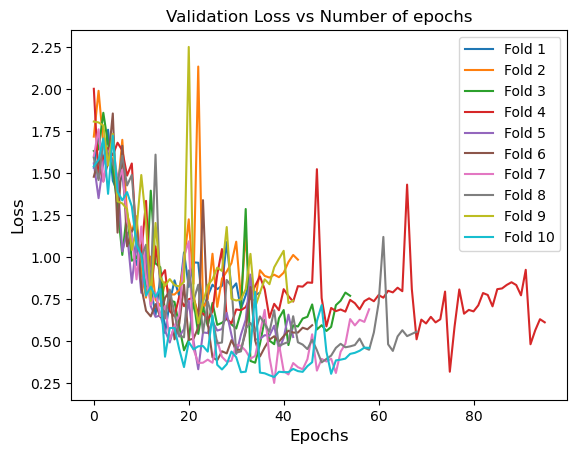

In [16]:

# Plot loss history
for i in range(len(history_by_fold)):
    plt.plot(history_by_fold[i].history["val_loss"], label = "Fold {}".format(i + 1))
plt.title("Validation Loss vs Number of epochs", fontsize = 12)
plt.xlabel("Epochs", fontsize = 12)
plt.ylabel("Loss", fontsize = 12)
plt.legend()
plt.show()


#### Show accuracy history by epochs.

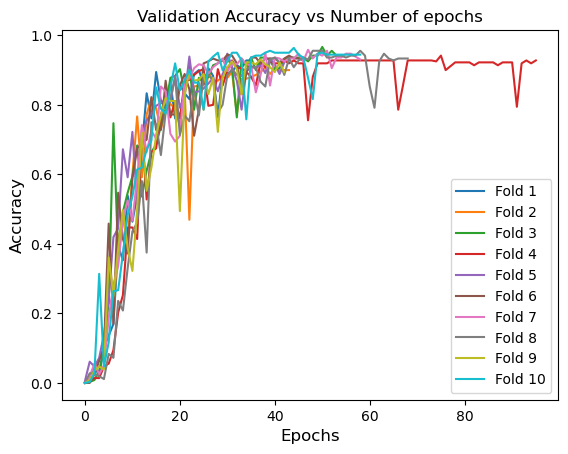

In [17]:

# Plot accuracy history
for i in range(len(history_by_fold)):
    plt.plot(history_by_fold[i].history["val_accuracy"], label = "Fold {}".format(i + 1))
plt.title("Validation Accuracy vs Number of epochs", fontsize = 12)
plt.xlabel('Epochs', fontsize = 12)
plt.ylabel('Accuracy', fontsize = 12)
plt.legend()
plt.show()
